In [1]:
import pandas as pd
import numpy as np
import re
import uuid
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans

import plotly.graph_objects as go

from sklearn.decomposition import PCA

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns=None
pd.options.mode.chained_assignment = None

C:\Users\User\AppData\Local\Temp\ipykernel_24744\3040544828.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
stud_feb= pd.read_excel(r'C:\Users\User\studenti_report\studenti_feb_24.xlsx')

In [5]:
# Добавление uuid
def text_to_uuid(text):
    return str(uuid.uuid5(uuid.NAMESPACE_DNS, text))
stud_feb.insert(0, 'uuid', stud_feb.apply(lambda row: text_to_uuid(' '.join(row['ФИО'])), axis=1))
stud_feb_fio_uuid_full=stud_feb.copy()
stud_feb_fio_uuid=stud_feb.drop_duplicates(subset='uuid')
# удаление лишних столбцов 
stud_feb.drop(columns=['ФИО','Номер ЛД','№п/п'], inplace=True)
# меняю названия столбцов
stud_feb=stud_feb.rename(columns={'Уровень подготовки':'degree','Специальность/направление':'faculty','Учебный год':'year','Полугодие':'semester','Дисциплина':'subject','Оценка (без пересдач)':'marks','Оценка (успеваемость)':'marks_final','Корпоративный Email':'email','Учебная группа':'group'})

In [6]:
# убираю все нули
# stud_feb = stud_feb.dropna(subset=['marks', 'marks_final'], how='all') 

In [7]:
# убираем будущее
stud_feb['marks'] = stud_feb['marks'].str.strip()
stud_feb['marks_final'] = stud_feb['marks_final'].str.strip()
stud_feb=stud_feb.query('year != "2024 - 2025" and year != "2025 - 2026" and year != "2026 - 2027" and year != "2027 - 2028" and year != "2028 - 2029" and year != "2029 - 2030" ').reset_index(drop=True)


In [8]:
# год и семестр вместе, убираем еще один слой будущего 
stud_feb['date']=stud_feb['year'] + stud_feb['semester']
stud_feb['date'] = stud_feb['date'].str.strip()
stud_feb=stud_feb.query('date != "2023 - 2024II полугодие"')


In [9]:
dict={"2020 - 2021I полугодие": "20_21_semestr1",
    "2020 - 2021II полугодие": "20_21_semestr2",
    "2021 - 2022I полугодие": "21_22_semestr1",
    "2021 - 2022II полугодие": "21_22_semestr2",
    "2022 - 2023I полугодие": "22_23_semestr1",
    "2022 - 2023II полугодие": "22_23_semestr2",
    "2023 - 2024I полугодие": "23_24_semestr1"}
stud_feb['date'].replace(dict,inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_24744\1356810080.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stud_feb['date'].replace(dict,inplace=True)


In [10]:
# датафрейм, в котором в котором пропущенны оба значения в оценках 
stud_null = stud_feb[(stud_feb['marks'].isnull()) & (stud_feb['marks_final'].isnull())]

In [11]:
# выделяем курс студента для каждого наблюдения 

In [12]:
stud_feb['year_group'] = stud_feb['group'].str.extract(r'-(\d{2})-')

stud_feb['year_group'] = stud_feb['year_group'].astype(float)

stud_feb['year_group'] = stud_feb['year_group'].apply(lambda x: 2000 + x)

In [13]:
stud_feb['year_group'].value_counts()

year_group
2020.0    85636
2022.0    67105
2021.0    65600
2023.0    22204
2019.0    20618
2018.0    13565
2017.0      799
2016.0      627
Name: count, dtype: int64

In [14]:
stud_feb.head(3)

,uuid,email,subject,marks,marks_final,semester,year,faculty,degree,group,date,year_group
0,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Автоматизация технологических процессов,Хорошо,Хорошо,II полугодие,2022 - 2023,Информатика и вычислительная техника,Академический бакалавр,БИВТ-20-4,22_23_semestr2,2020.0
1,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Алгоритмы дискретной математики,Хорошо,Хорошо,II полугодие,2021 - 2022,Информатика и вычислительная техника,Академический бакалавр,БИВТ-20-4,21_22_semestr2,2020.0
2,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Базы данных,Хорошо,Хорошо,I полугодие,2021 - 2022,Информатика и вычислительная техника,Академический бакалавр,БИВТ-20-4,21_22_semestr1,2020.0


####  выбор нужного курса 

In [15]:
# к нижнему регистру столбец degree
stud_feb['degree'] = stud_feb['degree'].str.lower()

#выбираем только бакалавров
stud_feb = stud_feb[stud_feb['degree'].str.contains('бакалавр')]

In [16]:
# оставили только бакалвров, которые сейчас на 4 курсе 
stud_feb=stud_feb[stud_feb['year_group'] == 2020]

In [17]:
stud_feb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74416 entries, 0 to 349703
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uuid         74416 non-null  object 
 1   email        74416 non-null  object 
 2   subject      74406 non-null  object 
 3   marks        65134 non-null  object 
 4   marks_final  68350 non-null  object 
 5   semester     74406 non-null  object 
 6   year         74406 non-null  object 
 7   faculty      74416 non-null  object 
 8   degree       74416 non-null  object 
 9   group        74416 non-null  object 
 10  date         74406 non-null  object 
 11  year_group   74416 non-null  float64
dtypes: float64(1), object(11)
memory usage: 7.4+ MB


In [18]:
marks_null = stud_feb[stud_feb['marks_final'].isnull()]

In [19]:
marks_null.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6066 entries, 46 to 349697
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uuid         6066 non-null   object 
 1   email        6066 non-null   object 
 2   subject      6056 non-null   object 
 3   marks        1179 non-null   object 
 4   marks_final  0 non-null      object 
 5   semester     6056 non-null   object 
 6   year         6056 non-null   object 
 7   faculty      6066 non-null   object 
 8   degree       6066 non-null   object 
 9   group        6066 non-null   object 
 10  date         6056 non-null   object 
 11  year_group   6066 non-null   float64
dtypes: float64(1), object(11)
memory usage: 616.1+ KB


In [20]:
len(stud_feb['uuid'].unique())

1391

In [21]:
len(marks_null['uuid'].unique())

736

In [22]:
len(marks_null['subject'].unique())

393

In [23]:
marks_null['subject'].value_counts()

subject
Иностранный язык                                                                                        313
Методы тестирования и отладки программного обеспечения                                                  165
Математика                                                                                              132
Системы искусственного интеллекта для проектирования и дизайна                                          126
Интернет-технологии для проектирования и дизайна                                                        126
Разработка инновационных программных продуктов. Часть 2                                                 121
Проектирование ИСОИУ. Часть1                                                                            116
Макетирование                                                                                           115
Физика                                                                                                  115
Рисунок и живопись  

#### удаляем 20% случаев, где обе оценки пропущены 

In [24]:
# выделяем только тех, у кого обе оценки null 
vse_nuli=stud_feb[stud_feb['marks_final'].isnull() & stud_feb['marks'].isnull()]

In [25]:
grouped = vse_nuli.groupby('uuid')

# создаю датафрейм для сохранения строк после удаления 20% из каждой группы
nuli_out = pd.DataFrame(columns=vse_nuli.columns)

In [26]:
# оставляем 20% строк из каждой группы
for name, group in grouped:
    num_rows_to_keep = int(len(group) * 0.2)
    sampled_group = group.sample(n=num_rows_to_keep, random_state=42)  # Фиксируем random_state для воспроизводимости
    nuli_out = pd.concat([nuli_out, sampled_group])

C:\Users\User\AppData\Local\Temp\ipykernel_24744\324149620.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  nuli_out = pd.concat([nuli_out, sampled_group])


In [27]:
nuli_out.info()

<class 'pandas.core.frame.DataFrame'>
Index: 766 entries, 100399 to 224479
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uuid         766 non-null    object 
 1   email        766 non-null    object 
 2   subject      766 non-null    object 
 3   marks        0 non-null      object 
 4   marks_final  0 non-null      object 
 5   semester     766 non-null    object 
 6   year         766 non-null    object 
 7   faculty      766 non-null    object 
 8   degree       766 non-null    object 
 9   group        766 non-null    object 
 10  date         766 non-null    object 
 11  year_group   766 non-null    float64
dtypes: float64(1), object(11)
memory usage: 77.8+ KB


In [28]:
# удалил 20% оценок с двумя нулями, предполагая что это пустые предметы по выбору 
indexes_to_drop = nuli_out.index
stud_feb.drop(index=indexes_to_drop, inplace=True)

In [29]:
stud_feb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73650 entries, 0 to 349703
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uuid         73650 non-null  object 
 1   email        73650 non-null  object 
 2   subject      73640 non-null  object 
 3   marks        65134 non-null  object 
 4   marks_final  68350 non-null  object 
 5   semester     73640 non-null  object 
 6   year         73640 non-null  object 
 7   faculty      73650 non-null  object 
 8   degree       73650 non-null  object 
 9   group        73650 non-null  object 
 10  date         73640 non-null  object 
 11  year_group   73650 non-null  float64
dtypes: float64(1), object(11)
memory usage: 7.3+ MB


In [30]:
stud_feb.head(3)

,uuid,email,subject,marks,marks_final,semester,year,faculty,degree,group,date,year_group
0,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Автоматизация технологических процессов,Хорошо,Хорошо,II полугодие,2022 - 2023,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,22_23_semestr2,2020.0
1,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Алгоритмы дискретной математики,Хорошо,Хорошо,II полугодие,2021 - 2022,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,21_22_semestr2,2020.0
2,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Базы данных,Хорошо,Хорошо,I полугодие,2021 - 2022,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,21_22_semestr1,2020.0


#### унификация оценок неудовлетворительно 

In [31]:
# заменяю пропущенные значения в столбце marks значением 'неудовлетворительно'
stud_feb['marks'].fillna('неудовлетворительно', inplace=True)
# заполняю соответствующие строки в столбце marks_final значением 'неудовлетворительно'
stud_feb['marks_final'].fillna('неудовлетворительно', inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_24744\1957189399.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stud_feb['marks'].fillna('неудовлетворительно', inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_24744\1957189399.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

In [32]:
stud_feb['marks_final'] = stud_feb['marks_final'].replace(['Неудовлетворительно', 'не зачтено', 'Не допущен'], 'неудовлетворительно')
stud_feb['marks'] = stud_feb['marks'].replace(['Неудовлетворительно', 'не зачтено', 'Не допущен'], 'неудовлетворительно')

In [33]:
stud_feb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73650 entries, 0 to 349703
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uuid         73650 non-null  object 
 1   email        73650 non-null  object 
 2   subject      73640 non-null  object 
 3   marks        73650 non-null  object 
 4   marks_final  73650 non-null  object 
 5   semester     73640 non-null  object 
 6   year         73640 non-null  object 
 7   faculty      73650 non-null  object 
 8   degree       73650 non-null  object 
 9   group        73650 non-null  object 
 10  date         73640 non-null  object 
 11  year_group   73650 non-null  float64
dtypes: float64(1), object(11)
memory usage: 7.3+ MB


In [34]:
# студенты у которых пропущена дата предмет
data_subject_nuli=stud_feb[stud_feb['date'].isnull()]

In [35]:
stud_feb.dropna(inplace=True)

In [36]:
stud_feb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73640 entries, 0 to 349703
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uuid         73640 non-null  object 
 1   email        73640 non-null  object 
 2   subject      73640 non-null  object 
 3   marks        73640 non-null  object 
 4   marks_final  73640 non-null  object 
 5   semester     73640 non-null  object 
 6   year         73640 non-null  object 
 7   faculty      73640 non-null  object 
 8   degree       73640 non-null  object 
 9   group        73640 non-null  object 
 10  date         73640 non-null  object 
 11  year_group   73640 non-null  float64
dtypes: float64(1), object(11)
memory usage: 7.3+ MB


In [37]:
stud_feb.head()

,uuid,email,subject,marks,marks_final,semester,year,faculty,degree,group,date,year_group
0,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Автоматизация технологических процессов,Хорошо,Хорошо,II полугодие,2022 - 2023,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,22_23_semestr2,2020.0
1,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Алгоритмы дискретной математики,Хорошо,Хорошо,II полугодие,2021 - 2022,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,21_22_semestr2,2020.0
2,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Базы данных,Хорошо,Хорошо,I полугодие,2021 - 2022,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,21_22_semestr1,2020.0
3,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Безопасность жизнедеятельности,неудовлетворительно,зачтено,II полугодие,2021 - 2022,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,21_22_semestr2,2020.0
4,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Инженерная компьютерная графика,Хорошо,Хорошо,I полугодие,2020 - 2021,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,20_21_semestr1,2020.0


#### подготовка данных для кластеризации 

In [38]:
grouped_df_final = stud_feb.groupby(['uuid', 'date', 'marks_final']).size().reset_index(name='count_marks_final')

grouped_df_final.head()
# рассчитаем процент всех оценок для каждого uuid за все время 
total_per_semester = grouped_df_final.groupby(['uuid','date'])['count_marks_final'].transform('sum')
grouped_df_final['percentage'] = round((grouped_df_final['count_marks_final'] / total_per_semester) * 100,2)


In [39]:
grouped_df_final.head()

,uuid,date,marks_final,count_marks_final,percentage
0,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr1,Удовлетворительно,2,25.00
1,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr1,Хорошо,2,25.00
2,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr1,зачтено,4,50.00
3,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr2,Удовлетворительно,3,33.33
4,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr2,Хорошо,2,22.22


In [40]:
# теперь только двойки
dvoechki=grouped_df_final.query('marks_final == "неудовлетворительно"').reset_index(drop=True)
dvoechki.head()


,uuid,date,marks_final,count_marks_final,percentage
0,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr2,неудовлетворительно,1,11.11
1,00bcd658-be72-55ce-a55d-922033d24e8d,21_22_semestr1,неудовлетворительно,2,20.00
2,00bcd658-be72-55ce-a55d-922033d24e8d,22_23_semestr2,неудовлетворительно,3,27.27
3,00bcd658-be72-55ce-a55d-922033d24e8d,23_24_semestr1,неудовлетворительно,1,8.33
4,0118adcd-86a0-5556-aea3-19a1df4af3a0,20_21_semestr1,неудовлетворительно,3,50.00


In [41]:
# группируем и считаем накопительно 
dvoechki_pivot = dvoechki.pivot(index='uuid', columns='date', values='count_marks_final').fillna(0).reset_index()
dvoechki_pivot = dvoechki_pivot.set_index('uuid')
dvoechki_pivot_vsego=dvoechki_pivot.cumsum(axis=1).reset_index()
dvoechki_pivot_vsego.head(3)



date,uuid,20_21_semestr1,20_21_semestr2,21_22_semestr1,21_22_semestr2,22_23_semestr1,22_23_semestr2,23_24_semestr1
0,00bcd658-be72-55ce-a55d-922033d24e8d,0.0,1.0,3.0,3.0,3.0,6.0,7.0
1,0118adcd-86a0-5556-aea3-19a1df4af3a0,3.0,7.0,9.0,11.0,15.0,23.0,32.0
2,01699bac-b70b-5746-a02e-79ed75425f93,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [42]:
len(dvoechki_pivot_vsego['uuid'].unique())

1039

In [43]:
# считаю общее количество оценок в семестре 
marks_per_semestr = grouped_df_final.groupby(['uuid', 'date'])['count_marks_final'].sum()
marks_per_semestr=grouped_df_final.pivot_table(index='uuid', columns='date', values='count_marks_final',aggfunc=sum).fillna(0).reset_index()
marks_per_semestr=marks_per_semestr.set_index('uuid')
marks_per_semestr_vsego=marks_per_semestr.cumsum(axis=1).reset_index()

marks_per_semestr_vsego.head()


C:\Users\User\AppData\Local\Temp\ipykernel_24744\1393435048.py:3: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  marks_per_semestr=grouped_df_final.pivot_table(index='uuid', columns='date', values='count_marks_final',aggfunc=sum).fillna(0).reset_index()


date,uuid,20_21_semestr1,20_21_semestr2,21_22_semestr1,21_22_semestr2,22_23_semestr1,22_23_semestr2,23_24_semestr1
0,00bcd658-be72-55ce-a55d-922033d24e8d,8.0,17.0,27.0,36.0,43.0,54.0,66.0
1,00c4a339-6177-522d-8638-ce53266ae980,6.0,14.0,22.0,32.0,41.0,52.0,60.0
2,0118adcd-86a0-5556-aea3-19a1df4af3a0,6.0,16.0,23.0,31.0,43.0,57.0,71.0
3,01699bac-b70b-5746-a02e-79ed75425f93,6.0,14.0,22.0,34.0,43.0,52.0,61.0
4,01ee572a-44d0-53d9-a62e-c7ce700a7172,8.0,17.0,26.0,35.0,42.0,53.0,64.0


In [44]:
len(marks_per_semestr_vsego['uuid'].unique())

1381

In [45]:


# считаем процент двоек ко всем оценкам 
dvoechniki_list=list(dvoechki_pivot_vsego['uuid'])
marks_per_semestr_vsego_dvoechniki=marks_per_semestr_vsego.query('uuid in @dvoechniki_list')
dvoechki_pivot_vsego.head(3)
marks_per_semestr_vsego_dvoechniki.head(3)
dvoechki_pivot_vsego = dvoechki_pivot_vsego.set_index('uuid')
marks_per_semestr_vsego_dvoechniki = marks_per_semestr_vsego_dvoechniki.set_index('uuid')

dvoechki_vsego = dvoechki_pivot_vsego.div(marks_per_semestr_vsego_dvoechniki).round(2).fillna(0).reset_index()
dvoechki_vsego.head()

date,uuid,20_21_semestr1,20_21_semestr2,21_22_semestr1,21_22_semestr2,22_23_semestr1,22_23_semestr2,23_24_semestr1
0,00bcd658-be72-55ce-a55d-922033d24e8d,0.0,0.06,0.11,0.08,0.07,0.11,0.11
1,0118adcd-86a0-5556-aea3-19a1df4af3a0,0.5,0.44,0.39,0.35,0.35,0.40,0.45
2,01699bac-b70b-5746-a02e-79ed75425f93,0.0,0.00,0.00,0.00,0.00,0.00,0.02
3,01ee572a-44d0-53d9-a62e-c7ce700a7172,0.0,0.06,0.08,0.11,0.10,0.11,0.11
4,02150b30-8a2f-5eb6-a428-f128a471dc35,0.0,0.00,0.00,0.00,0.00,0.00,0.08


In [46]:
len(dvoechki_vsego['uuid'].unique())

1039

In [47]:
dvoechki.head(10)

,uuid,date,marks_final,count_marks_final,percentage
0,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr2,неудовлетворительно,1,11.11
1,00bcd658-be72-55ce-a55d-922033d24e8d,21_22_semestr1,неудовлетворительно,2,20.00
2,00bcd658-be72-55ce-a55d-922033d24e8d,22_23_semestr2,неудовлетворительно,3,27.27
3,00bcd658-be72-55ce-a55d-922033d24e8d,23_24_semestr1,неудовлетворительно,1,8.33
4,0118adcd-86a0-5556-aea3-19a1df4af3a0,20_21_semestr1,неудовлетворительно,3,50.00
5,0118adcd-86a0-5556-aea3-19a1df4af3a0,20_21_semestr2,неудовлетворительно,4,40.00
6,0118adcd-86a0-5556-aea3-19a1df4af3a0,21_22_semestr1,неудовлетворительно,2,28.57
7,0118adcd-86a0-5556-aea3-19a1df4af3a0,21_22_semestr2,неудовлетворительно,2,25.00
8,0118adcd-86a0-5556-aea3-19a1df4af3a0,22_23_semestr1,неудовлетворительно,4,33.33
9,0118adcd-86a0-5556-aea3-19a1df4af3a0,22_23_semestr2,неудовлетворительно,8,57.14


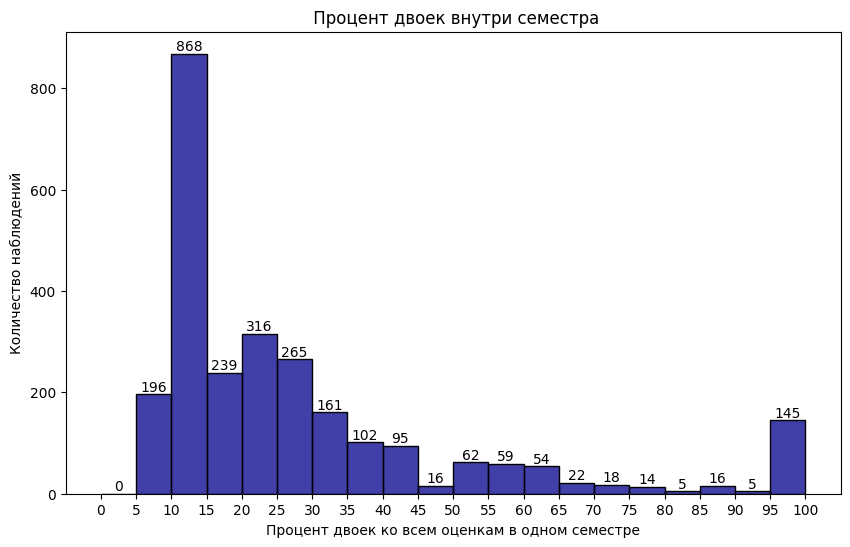

In [48]:

# распределение процента двоек ко всем оценкам внури семестра за все время обучения 
# над каждым столбцом указано количество наблюдений, которые попадают в этот промежуток 
x_ticks = np.arange(0, 101, 5)

# распределение процента исправленных двоек 
plt.figure(figsize=(10, 6))
histogram=sns.histplot(dvoechki['percentage'], bins=range(0, 101, 5), kde=False, color='darkblue')
plt.xticks(x_ticks)
plt.title(' Процент двоек внутри семестра')
plt.xlabel('Процент двоек ко всем оценкам в одном семестре')
plt.ylabel('Количество наблюдений')

# количество наблюдений в каждой группе
for p in histogram.patches:
    histogram.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

In [49]:
len(dvoechki['uuid'].unique())

1039

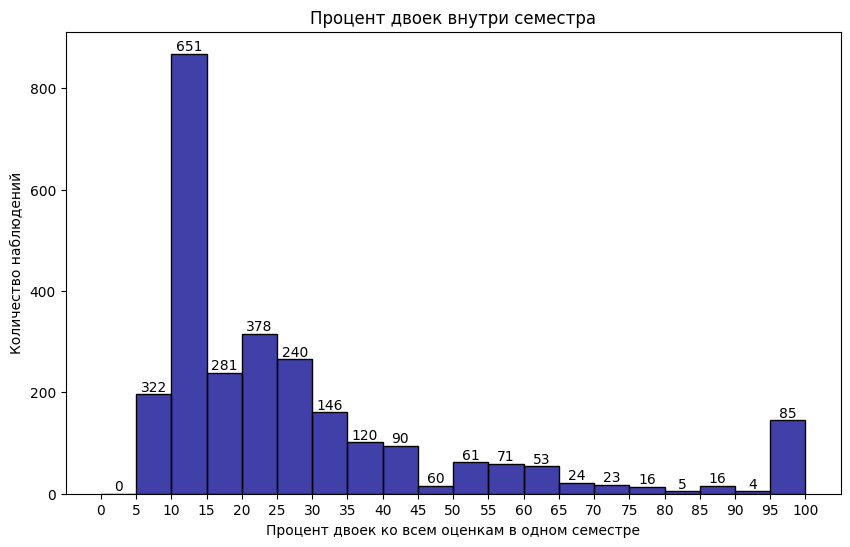

In [50]:
# распределение процента двоек ко всем оценкам внури семестра за все время обучения 
# над каждым столбцом указано количество студентов, которые попадают в этот промежуток
# наблюдения связынные с одним студентом могут быть в разных бинах, поэтому сумма чисел над
# столбцами больше чем общее количество студентов двоечников (1039)
x_ticks = np.arange(0, 101, 5)

# Распределение процента исправленных двоек
plt.figure(figsize=(10, 6))
histogram = sns.histplot(dvoechki['percentage'], bins=range(0, 101, 5), kde=False, color='darkblue')
plt.xticks(x_ticks)
plt.title('Процент двоек внутри семестра')
plt.xlabel('Процент двоек ко всем оценкам в одном семестре')
plt.ylabel('Количество наблюдений')

# Количество уникальных студентов в каждом бине
for p in histogram.patches:
    bin_mask = dvoechki['percentage'].between(p.get_x(), p.get_x() + p.get_width())
    students_count = dvoechki[bin_mask]['uuid'].nunique()
    histogram.annotate(f'{students_count}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

In [51]:
dvoechki['count_marks_final'].max()

14

In [52]:
dvoechki['count_marks_final'].value_counts()

count_marks_final
1     1089
2      622
3      346
4      167
5      106
7       84
8       75
6       72
9       58
10      33
11       3
13       2
14       1
Name: count, dtype: int64

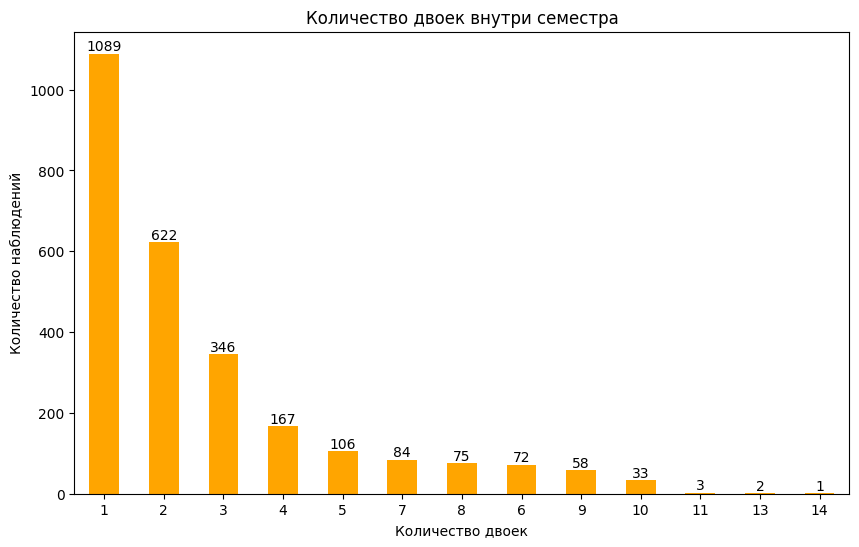

In [53]:
# распределение двоечников по количеству полученных двоек за один семестр для всех вариантов двоек, полученных в одну сессию 

# Подсчет количества уникальных значений в столбце count_marks_final
unique_counts = dvoechki['count_marks_final'].value_counts()

# Распределение двоечников по количеству полученных двоек за один семестр для всех вариантов двоек, полученных в одну сессию
plt.figure(figsize=(10, 6))
unique_counts.plot(kind='bar', color='orange')
plt.title('Количество двоек внутри семестра')
plt.xlabel('Количество двоек')
plt.ylabel('Количество наблюдений')

plt.xticks(rotation=0)



# Количество наблюдений в каждой группе
for i, count in enumerate(unique_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

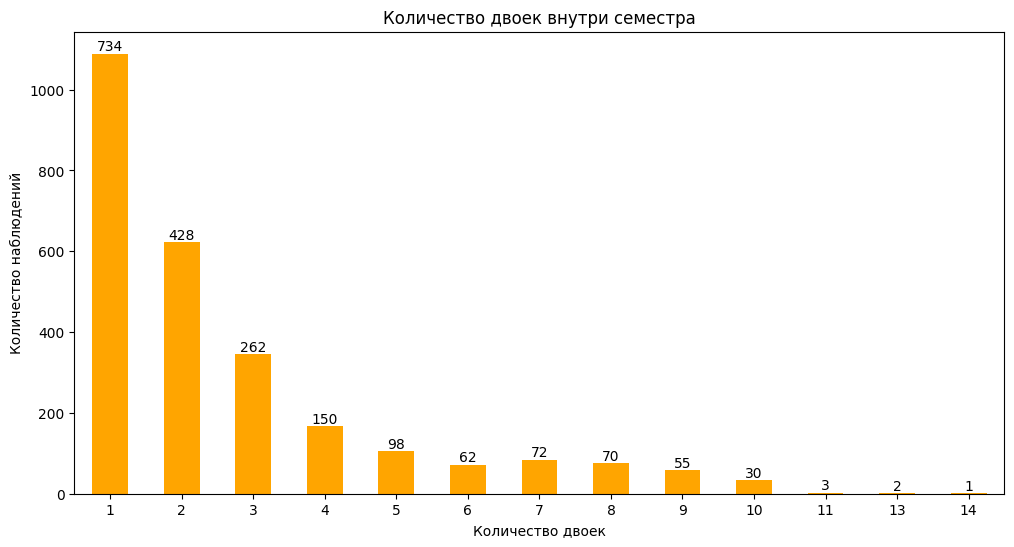

In [54]:
# распределение двоечников по количеству полученных двоек за один семестр для всех вариантов двоек, полученных в одну сессию 
# только теперь над столбцами количество студентов, у которых было столько двоек 
grouped_data = dvoechki.groupby('count_marks_final')['uuid'].agg(['count', 'nunique'])

# Распределение двоечников по количеству полученных двоек за один семестр для всех вариантов двоек, полученных в одну сессию
plt.figure(figsize=(12, 6))
grouped_data['count'].plot(kind='bar', color='orange')
plt.title('Количество двоек внутри семестра')
plt.xlabel('Количество двоек')
plt.ylabel('Количество наблюдений')
plt.xticks(rotation=0)

# Количество уникальных uuid в каждой группе
for i, count in enumerate(grouped_data['nunique']):
    plt.text(i, grouped_data['count'].iloc[i], str(count), ha='center', va='bottom')

plt.show()

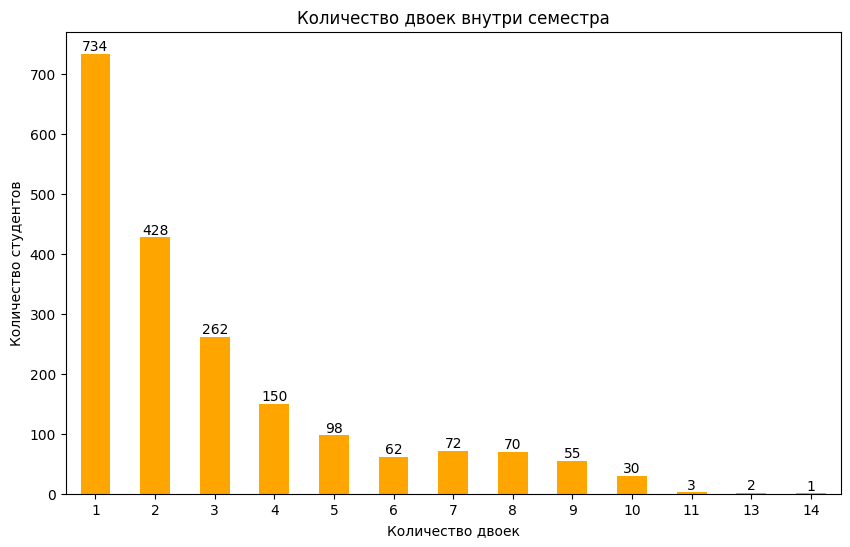

In [55]:
# распределение двоечников по количеству полученных двоек за один семестр для всех вариантов двоек, полученных в одну сессию 
# Группировка данных по количеству двоек и уникальным uuid
grouped_data = dvoechki.groupby('count_marks_final')['uuid'].nunique()

# Распределение двоечников по количеству полученных двоек за один семестр для всех вариантов двоек, полученных в одну сессию
plt.figure(figsize=(10, 6))
grouped_data.plot(kind='bar', color='orange')
plt.title('Количество двоек внутри семестра')
plt.xlabel('Количество двоек')
plt.ylabel('Количество студентов')

plt.xticks(rotation=0)

# Количество уникальных uuid в каждой группе
for i, count in enumerate(grouped_data):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [56]:
dvoechki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   uuid               2658 non-null   object 
 1   date               2658 non-null   object 
 2   marks_final        2658 non-null   object 
 3   count_marks_final  2658 non-null   int64  
 4   percentage         2658 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 104.0+ KB


In [57]:

# Count of failds_corrected_percent values
# count_marks_final_counts = dvoechki['count_marks_final'].value_counts()

# Plotting pie chart
#plt.figure(figsize=(8, 8))  # Define figure size
#plt.pie(count_marks_final_counts, labels=count_marks_final_counts.index, autopct='%1.1f%%', colors=plt.cm.tab20.colors)
#plt.title('Distribution of Final Marks')
#plt.show()

In [58]:
# распределение для количества двоек за все время учебы
dvoechki_pivot_vsego['dvoiki_sum']=dvoechki_pivot_vsego[['20_21_semestr1', '20_21_semestr2', '21_22_semestr1', '21_22_semestr2',
       '22_23_semestr1', '22_23_semestr2', '23_24_semestr1']].sum(axis=1)

In [59]:
dvoechki_pivot_vsego.columns    

Index(['20_21_semestr1', '20_21_semestr2', '21_22_semestr1', '21_22_semestr2',
       '22_23_semestr1', '22_23_semestr2', '23_24_semestr1', 'dvoiki_sum'],
      dtype='object', name='date')

In [60]:
dvoechki_pivot_vsego['dvoiki_sum'].max()

175.0

In [61]:
# вывести людей от 80 двоек посмотреть на них

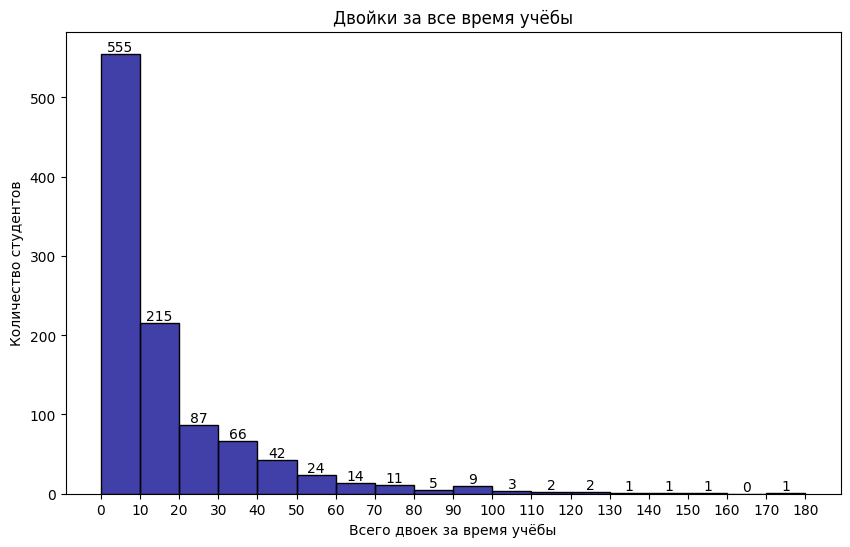

In [62]:
# распределение двоек за все время учебы 
# шаги на оси ox
x_ticks = np.arange(0, 185, 10)

# распределение процента исправленных двоек 
plt.figure(figsize=(10, 6))
histogram=sns.histplot(dvoechki_pivot_vsego['dvoiki_sum'], bins=range(0, 185,10), kde=False, color='darkblue')
plt.xticks(x_ticks)
plt.title('Двойки за все время учёбы')
plt.xlabel('Всего двоек за время учёбы')
plt.ylabel('Количество студентов')

# количество наблюдений в каждой группе
for p in histogram.patches:
    histogram.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

#### кластеры графики

In [63]:
dvoechki_vsego=dvoechki_vsego.set_index('uuid')

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users

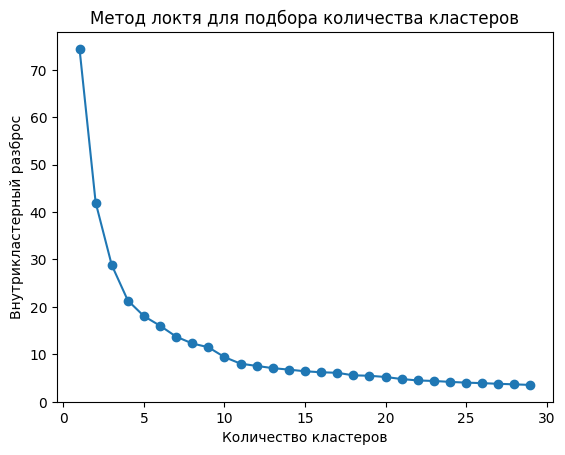

In [64]:
# по графику видно что если увеличивать количество кластеров после 5, разброс меняется незначительно, остановимся на 5 кластерах 
# подбор оптимального количества кластеров
inertia = []
for n_clusters in range(1, 30):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(dvoechki_vsego)
    inertia.append(kmeans.inertia_)

# локоть
plt.plot(range(1, 30), inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Внутрикластерный разброс')
plt.title('Метод локтя для подбора количества кластеров')
plt.show()

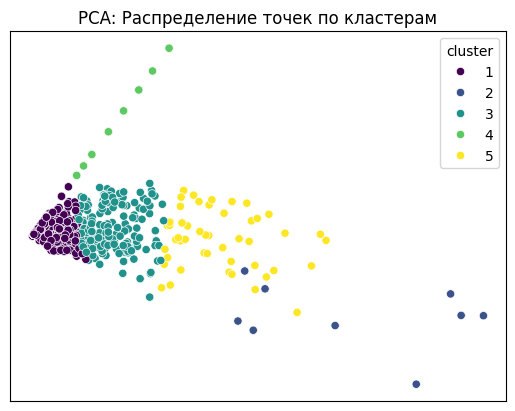

In [65]:
# 5 КЛАСТЕРОВ без подписей

dvoechki_vsego_2020_5_clusters = dvoechki_vsego.copy()

# Задаем количество кластеров
n_clusters = 5

# Применяем метод k-средних для кластеризации
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(dvoechki_vsego)
cluster_labels += 1

# Добавляем метки кластеров в датафрейм
dvoechki_vsego_2020_5_clusters['cluster'] = cluster_labels

# Применяем PCA для уменьшения размерности
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dvoechki_vsego)

# Создаем датафрейм с результирующими данными PCA
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
dvoechki_dinamika_copy = dvoechki_vsego_2020_5_clusters.reset_index(drop=True)
pca_df['cluster'] = dvoechki_dinamika_copy['cluster']

# Строим график рассеяния без меток осей и точек
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis')
plt.title('PCA: Распределение точек по кластерам')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.show()


#### анализ кластеров

In [66]:
cluster_stats = dvoechki_vsego_2020_5_clusters.groupby('cluster').mean()*100
cluster_sizes = dvoechki_vsego_2020_5_clusters['cluster'].value_counts(normalize=True).sort_index()
cluster_numbers = dvoechki_vsego_2020_5_clusters['cluster'].value_counts().sort_index()

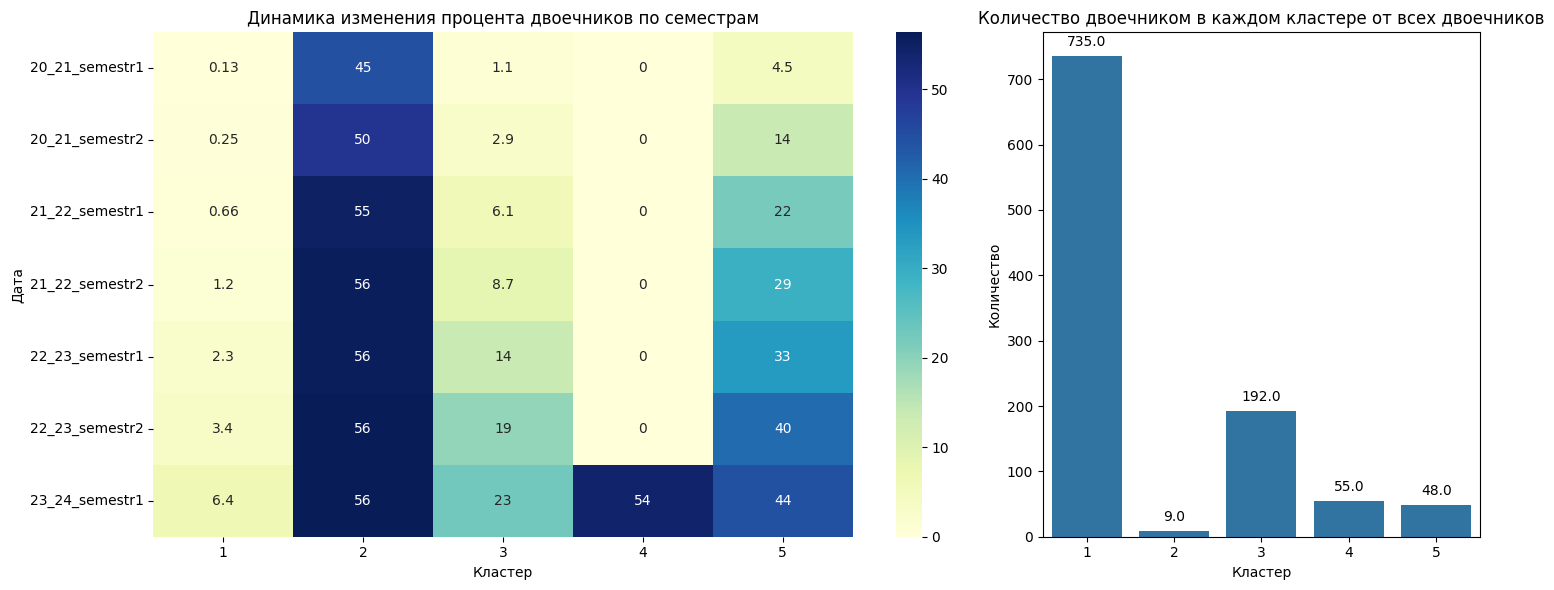

In [67]:
# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [4, 2]})

# График средних значений
sns.heatmap(cluster_stats.T, annot=True, cmap="YlGnBu", ax=ax1)
ax1.set_title('Динамика изменения процента двоечников по семестрам')
ax1.set_xlabel('Кластер')
ax1.set_ylabel('Дата')

# График размеров кластеров
bar_plot = sns.barplot(x=cluster_numbers.index, y=cluster_numbers.values, ax=ax2)
ax2.set_title('Количество двоечником в каждом кластере от всех двоечников')
ax2.set_xlabel('Кластер')
ax2.set_ylabel('Количество')

# Добавляем текст с размерами кластеров наверху столбиков
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

#### анализ кластеров

In [68]:
dvoechki_clusters=dvoechki_vsego_2020_5_clusters.reset_index()   
dvoechki_clusters.head(3)

date,uuid,20_21_semestr1,20_21_semestr2,21_22_semestr1,21_22_semestr2,22_23_semestr1,22_23_semestr2,23_24_semestr1,cluster
0,00bcd658-be72-55ce-a55d-922033d24e8d,0.0,0.06,0.11,0.08,0.07,0.11,0.11,3
1,0118adcd-86a0-5556-aea3-19a1df4af3a0,0.5,0.44,0.39,0.35,0.35,0.40,0.45,2
2,01699bac-b70b-5746-a02e-79ed75425f93,0.0,0.00,0.00,0.00,0.00,0.00,0.02,1


In [69]:
dvoechki_clusters['cluster'].value_counts()

cluster
1    735
3    192
4     55
5     48
2      9
Name: count, dtype: int64

In [70]:
# получаем датафреймы для каждого кластера 
clustered_dfs = []

# Проходим по каждому кластеру
for cluster in range(1, 6):
    # Фильтруем строки, принадлежащие текущему кластеру
    cluster_data = dvoechki_clusters[dvoechki_clusters['cluster'] == cluster].copy()
    
    # Добавляем столбец с номером кластера
    cluster_data['cluster'] = cluster
    
    # Добавляем текущий датафрейм в список
    clustered_dfs.append(cluster_data)


In [71]:
len(clustered_dfs)

5

In [72]:
# отбираем данные для анализ групп и факультетов
stud_feb_common=stud_feb[['uuid','faculty', 'group']].drop_duplicates(subset='uuid').reset_index(drop=True)
dvoechki_clusters=dvoechki_clusters.reset_index()
dvoechniki_with_common=pd.merge(dvoechki_clusters[['uuid','cluster']],stud_feb_common,how='inner',on='uuid')

In [73]:
dvoechniki_with_common.head()

,uuid,cluster,faculty,group
0,00bcd658-be72-55ce-a55d-922033d24e8d,3,Экономика,БЭК-20-1
1,0118adcd-86a0-5556-aea3-19a1df4af3a0,2,Металлургия,БМТ-20-1
2,01699bac-b70b-5746-a02e-79ed75425f93,1,Информатика и вычислительная техника,БИВТ-20-6
3,01ee572a-44d0-53d9-a62e-c7ce700a7172,3,Экономика,БЭК-20-1
4,02150b30-8a2f-5eb6-a428-f128a471dc35,1,Лингвистика,БЛГ-20-9


In [74]:
dvoechniki_with_common.head()

,uuid,cluster,faculty,group
0,00bcd658-be72-55ce-a55d-922033d24e8d,3,Экономика,БЭК-20-1
1,0118adcd-86a0-5556-aea3-19a1df4af3a0,2,Металлургия,БМТ-20-1
2,01699bac-b70b-5746-a02e-79ed75425f93,1,Информатика и вычислительная техника,БИВТ-20-6
3,01ee572a-44d0-53d9-a62e-c7ce700a7172,3,Экономика,БЭК-20-1
4,02150b30-8a2f-5eb6-a428-f128a471dc35,1,Лингвистика,БЛГ-20-9


In [75]:
dvoechniki_with_common['group'] = dvoechniki_with_common['group'].str.extract(r'^(.*?-.*?)-', expand=False)
dvoechniki_with_common.head()

,uuid,cluster,faculty,group
0,00bcd658-be72-55ce-a55d-922033d24e8d,3,Экономика,БЭК-20
1,0118adcd-86a0-5556-aea3-19a1df4af3a0,2,Металлургия,БМТ-20
2,01699bac-b70b-5746-a02e-79ed75425f93,1,Информатика и вычислительная техника,БИВТ-20
3,01ee572a-44d0-53d9-a62e-c7ce700a7172,3,Экономика,БЭК-20
4,02150b30-8a2f-5eb6-a428-f128a471dc35,1,Лингвистика,БЛГ-20


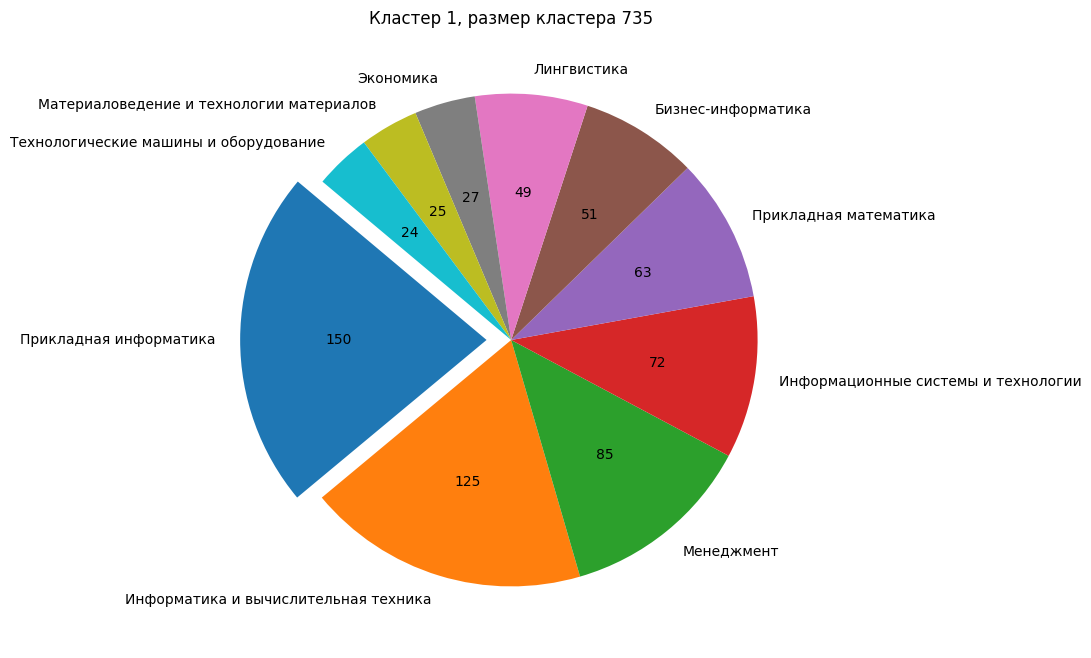

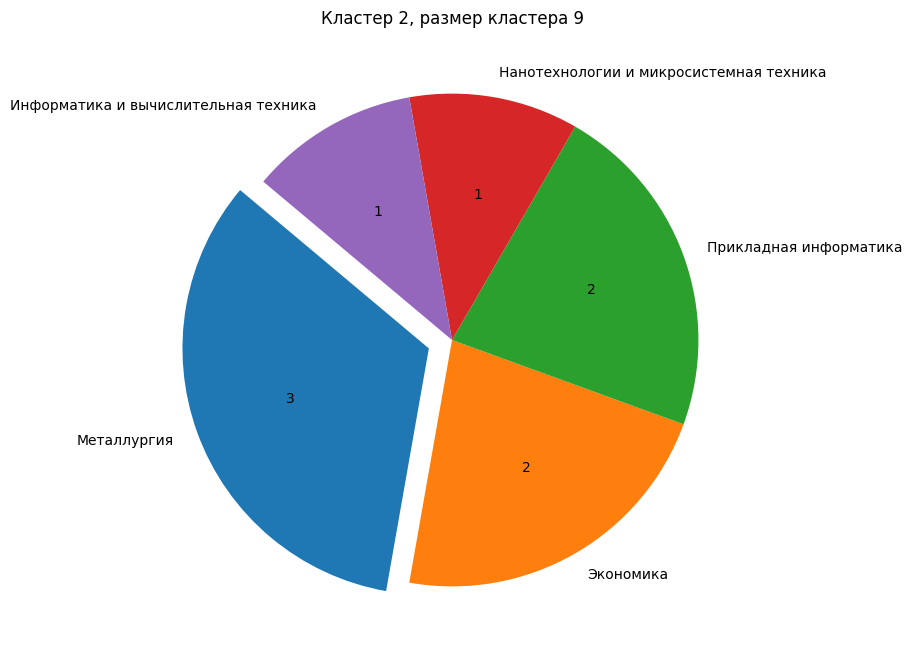

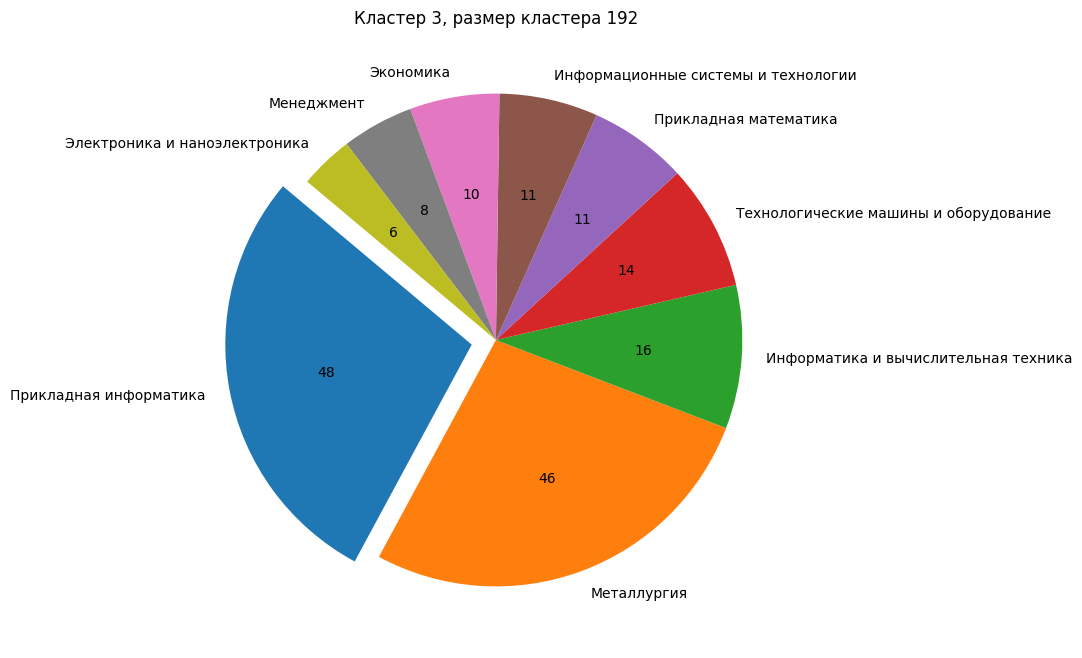

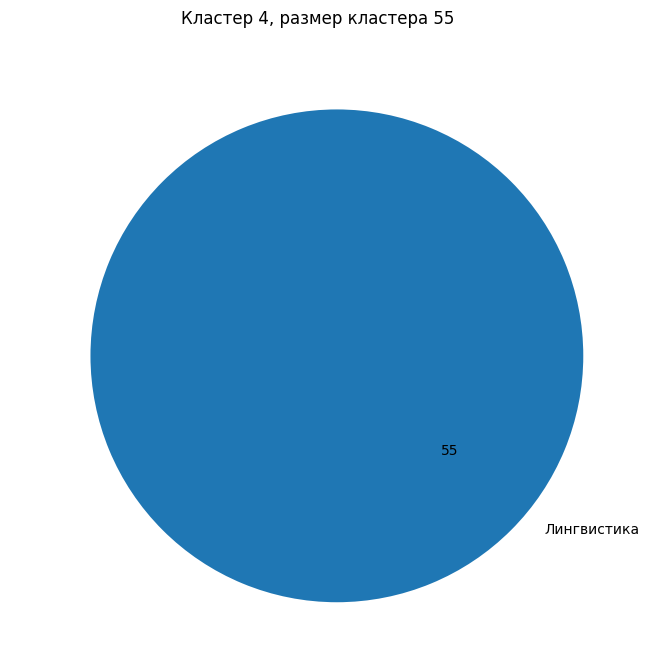

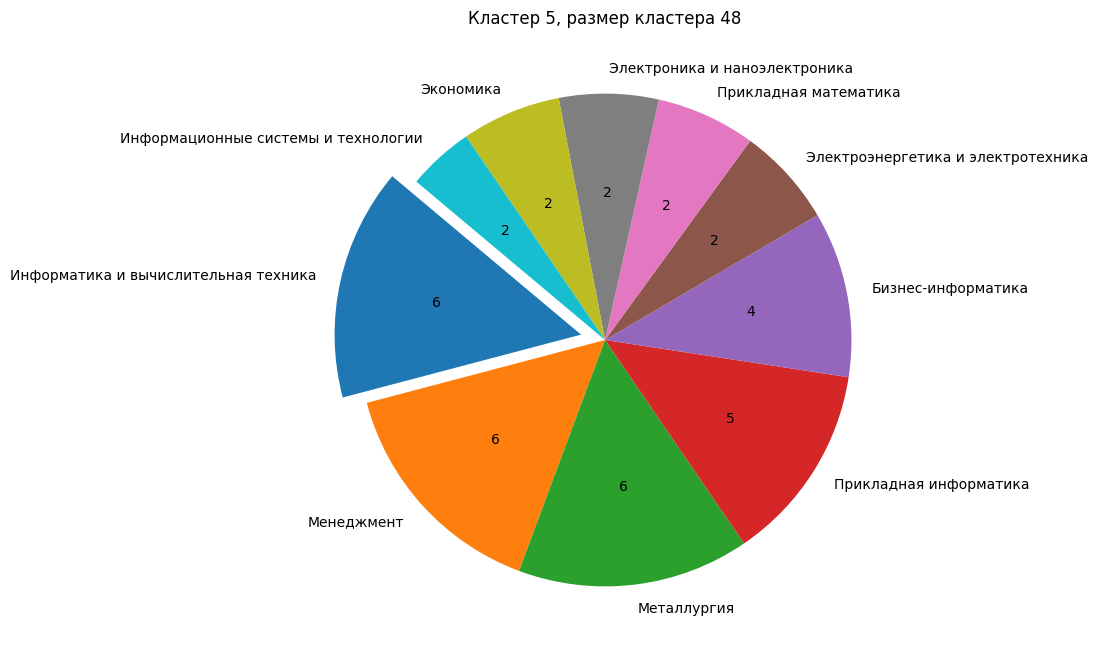

In [76]:
# факультеты
grouped_clusters = dvoechniki_with_common.groupby('cluster')

# Создание отдельных таблиц для каждого кластера
cluster_tables = {}  # Словарь для хранения таблиц

for cluster, group_data in grouped_clusters:
    # Создание таблицы для текущего кластера
    cluster_table = pd.DataFrame()

    # Количество наблюдений для каждого факультета
    faculty_counts = group_data['faculty'].value_counts()

    # Добавление данных в таблицу
    cluster_table['Faculty Counts'] = faculty_counts

    # Сохранение таблицы в словарь
    cluster_tables[cluster] = cluster_table

    # Размер кластера
    cluster_size = len(group_data)

    # Построение круговой диаграммы
    plt.figure(figsize=(8, 8))
    threshold = 0.03  # Порог для отображения секторов
    relevant_faculties = faculty_counts[faculty_counts / faculty_counts.sum() > threshold]
    explode = (relevant_faculties.index == relevant_faculties.idxmax()).astype(float) * 0.1  # Выделение максимального сектора
    plt.pie(relevant_faculties, labels=relevant_faculties.index, autopct=lambda p: f'{int(p * sum(relevant_faculties) / 100)}', startangle=140, explode=explode)
    plt.title(f'Кластер {cluster}, размер кластера {cluster_size}')
    plt.show()

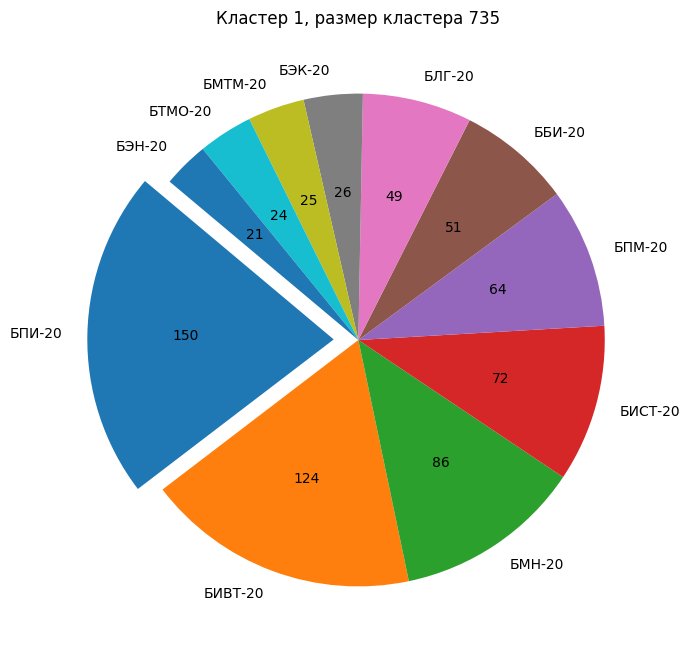

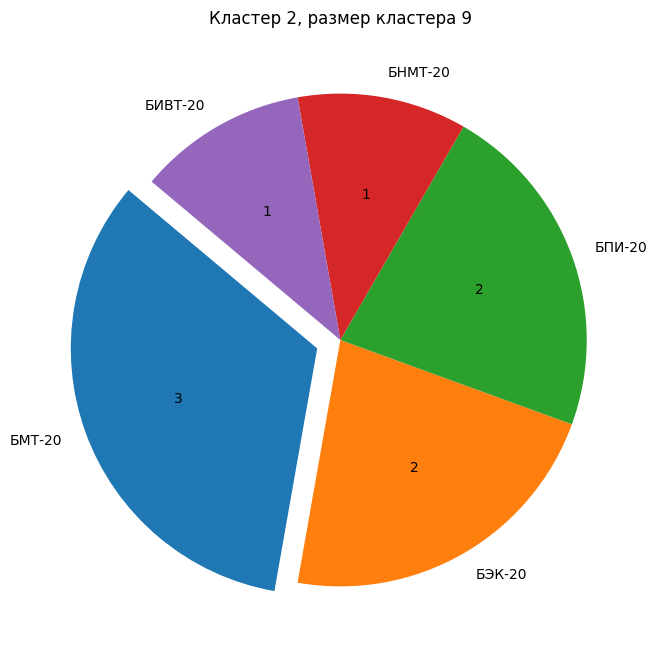

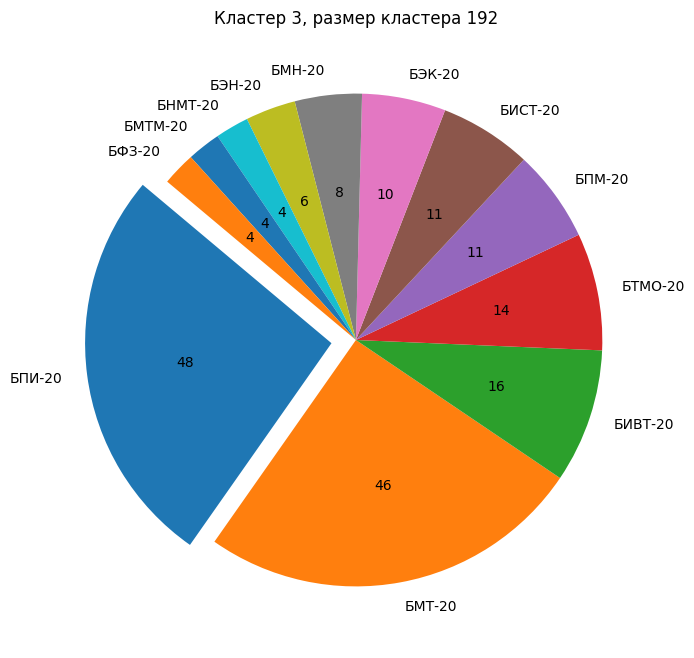

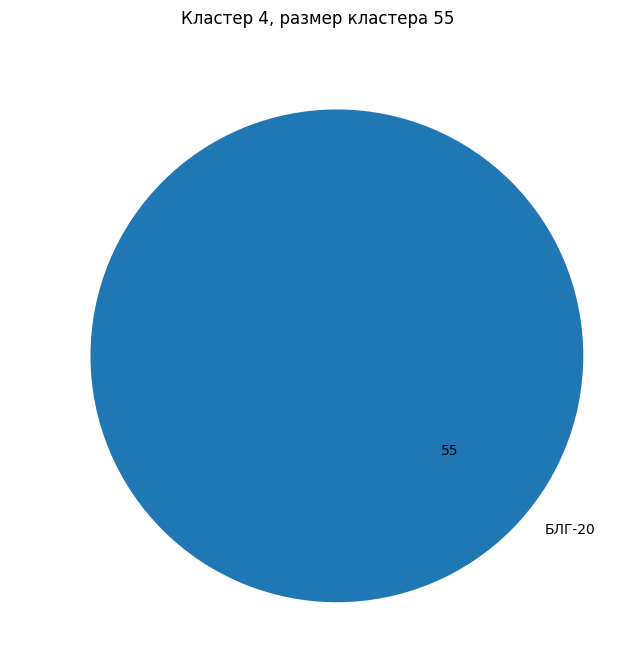

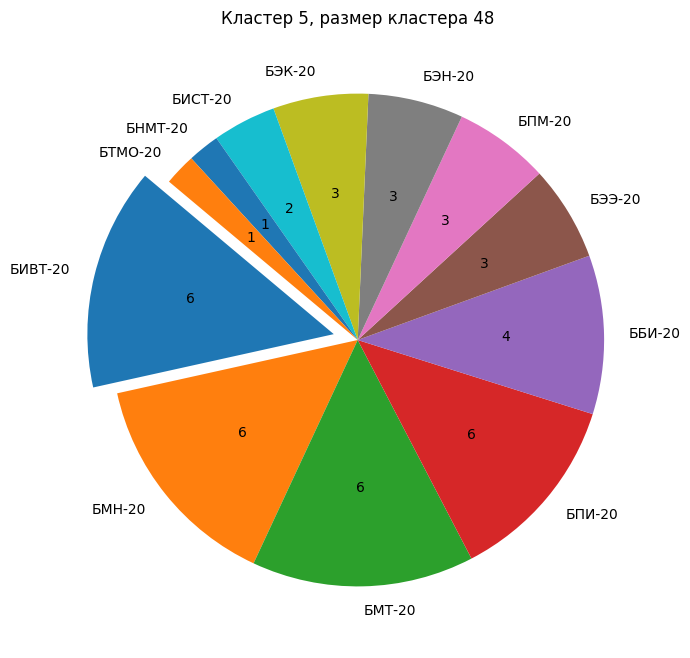

In [77]:
# группы
# разбить по потокам убрать цифры после года 
cluster_tables_group = {}  # Словарь для хранения таблиц

for cluster, group_data in grouped_clusters:
    # Создание таблицы для текущего кластера
    cluster_table = pd.DataFrame()

    # Количество наблюдений для каждого факультета
    faculty_counts = group_data['group'].value_counts()

    # Добавление данных в таблицу
    cluster_table['Faculty Counts'] = faculty_counts

    # Сохранение таблицы в словарь
    cluster_tables_group[cluster] = cluster_table

    # Размер кластера
    cluster_size = len(group_data)

    # Построение круговой диаграммы
    plt.figure(figsize=(8, 8))
    threshold = 0.02  # Порог для отображения секторов
    relevant_faculties = faculty_counts[faculty_counts / faculty_counts.sum() > threshold]
    explode = (relevant_faculties.index == relevant_faculties.idxmax()).astype(float) * 0.1  # Выделение максимального сектора
    plt.pie(relevant_faculties, labels=relevant_faculties.index, autopct=lambda p: f'{int(p * sum(relevant_faculties) / 100)}', startangle=140, explode=explode)
    plt.title(f'Кластер {cluster}, размер кластера {cluster_size}')
    plt.show()